<a href="https://colab.research.google.com/github/Kienknu/Kienknu/blob/main/K_SOA_m_Xylene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**m-Xylene**

In [ ]:
!pip install rdkit
!pip install molmass
!pip install pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 11.1 MB/s eta 0:00:00


In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
from rdkit.Chem import Descriptors
import pandas as pd
import requests
import io
from molmass import Formula
import matplotlib.pyplot as plt
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem, DataStructs
import numpy as np
from pyscf import gto, scf
import re

**1. Functions definition**

In [ ]:
#--- RDKit Fingerprints----#
def cluster_and_filter(mols, cutoff):
    mols = [mol for mol in mols if mol is not None]
    if not mols:
        return []
    # Genete RDKit Fingerprints
    fps = [AllChem.RDKFingerprint(mol) for mol in mols]

    num_mols = len(mols)
    dists = []
    for i in range(1, num_mols):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1 - x for x in sims])

    clusters = Butina.ClusterData(dists, num_mols, cutoff, isDistData=True)
    unique_mols = [mols[cluster[0]] for cluster in clusters]
    return unique_mols

#--- PubChem checking---#
def check_pubchem_by_smiles(smiles):
    """
    Checks if a compound with the given SMILES exists in PubChem.

    Args:
        smiles (str): The SMILES string of the compound to check.

    Returns:
        tuple: (bool is_found, str or None cid_value).
               is_found is True if a CID (0 or positive) is returned, False otherwise.
               cid_value is the CID as a string if found, None otherwise.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{requests.utils.quote(smiles)}/cids/JSON"

    try:
        response = requests.get(url)
        response.raise_for_status()

        data = response.json()

        if 'IdentifierList' in data and data['IdentifierList']['CID']:
            cid = data['IdentifierList']['CID'][0]
            return True, str(cid)
        else:
            return False, None

    except requests.exceptions.RequestException as e:
        return False, None
    except ValueError:
        return False, None

# Mass calculation
def calculate_monoisotopic_masses(formula):
    try:
        f = Formula(formula)
        mono_mass = f.isotope.mass  # Monoisotopic mass
        hydrogen_isotope_mass = Formula('H').isotope.mass

        mh_mass = mono_mass - hydrogen_isotope_mass
        mph_mass = mono_mass + hydrogen_isotope_mass
        return mono_mass, mh_mass, mph_mass
    except Exception as e:
        print(f"Error with formula {formula}: {e}")
        return None, None, None

# Trace all pathways
def trace_reaction_path_all(target_product_smiles, reaction_history, current_path=None, all_paths=None, visited_paths=None):
    """Traces ALL unique reaction pathways through reaction_history."""

    if current_path is None:
        current_path = []
    if all_paths is None:
        all_paths = []
    if visited_paths is None:
        visited_paths = set()

    # Find all steps in reaction_history that produce the target_product_smiles
    producing_steps = [(i, step) for i, step in enumerate(reaction_history) if step[2] == target_product_smiles]

    if not producing_steps:
        if current_path:
            path_tuple = tuple(current_path)
            if path_tuple not in visited_paths:
                all_paths.append(list(reversed(current_path)))
                visited_paths.add(path_tuple)
        return all_paths

    for original_index, step in producing_steps:
        reactant, rxn_index, product = step

        # Create a new path by adding the current step
        new_step = (reactant, rxn_index, product)
        new_path = current_path + [new_step]

        # Recursively trace the reactant
        trace_reaction_path_all(reactant, reaction_history, current_path=new_path, all_paths=all_paths, visited_paths=visited_paths)

    return all_paths

**2. Simulation**

In [ ]:
reaction_rules = [

    #------------------------------------------Selected group---------------------------------------#

    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][N+](=O)[O-]'),                              #0: Aromatic Nitration
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][N](=O)'),                                   #1: Aromatic Nitrosation
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1]OO'),                                        #2: Aromatic Hydroperoxidation
    AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][C:2]=O'),                             #3: Benzylic Methyl Oxidation
    AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][CH2:2][OH]'),                         #4: Benzylic Methyl Hydroxylation
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][O][N+](=O)[O-]'),                           #5: Aromatic Nitrate Ester fomation

    #-----Nitration: NO₂ group addition----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N+](=O)[O-]'),                            #6: Aliphatic Nitration

    #-----Nitrosation: NO group addition----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N](=O)'),                                 #7: Aliphatic Nitrosation

    #-----Hydroperoxide Formation----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]OO'),                                      #8: Aliphatic Hydroperoxidation

    #-----Oligomerization----#
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH]=[CH][C:2]'),                        #9: Oligomerization (Alkene)
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH][CH2][C:2]'),                        #10: Oligomerization(Branched)

    #-----Nitrate ester formation----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][O][N+](=O)[O-]'),                         #11: Aliphatic Nitrate Ester formation

    # OH radical substitution on methyl
    AllChem.ReactionFromSmarts('[CH3:1]>>[OH:1]'),                                        #12: Methyl to Hydroxyl Substitution

    #--------------# SO2 Atmospheric Chemistry Rules ---------------#
    # 1. Direct SO2 addition (Aromatic sulfonation)
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1]S(=O)(=O)O'),                                #13: Aromatic Sulfonation (Direct)
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]S(=O)(=O)O'),                              #14: Aliphatic/Cyclic Sulfonation (Direct)

    # 2. Sulfonic acid formation from organics (Benzylic sulfonation)
    AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][CH2:2]S(=O)(=O)O'),                   #15: Benzylic Sulfonation

    # 3. Organosulfate formation (Secondary organosulfate)
    AllChem.ReactionFromSmarts('[C:1]([OH:2])[C:3]>>[C:1]([O:2]S(=O)(=O)O)[C:3]'),        #16: Secondary Organosulfate Formation

    #----------------------------------- From MCM Web------------------------------#
    AllChem.ReactionFromSmarts('Cc1cccc(C)c1>>[O]OC1C=CC2(C)OOC1(C)C2O'),                  #17: m-Xylene to MXYBIPERO2 (selected)
    AllChem.ReactionFromSmarts('Cc1cccc(C)c1>>O=CC1(C)OC1C=CC(=O)C'),                      #18: m-Xylene to MXYEPOXMUC (selected)
    AllChem.ReactionFromSmarts('Cc1cccc(C)c1>>Cc1ccc(O)c(C)c1'),                           #19: m-Xylene to MXYLOL-
    AllChem.ReactionFromSmarts('Cc1cccc(C)c1>>[O]OCc1cccc(C)c1'),                          #20: m-Xylene to MXYLO2-

    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>[O]C1C=CC2(C)OOC1(C)C2O'),       #21: MXYBIPERO2 to MXYBIPERO(1.1)
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>O=N(=O)OC1C=CC2(C)OOC1(C)C2O'),  #22: MXYBIPERO2 to MXYBIPENO3(1.2)
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>OOC1C=CC2(C)OOC1(C)C2O'),        #23: MXYBIPERO2 to MXYBPEROOH(1.3)
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>OC1C=CC2(C)OOC1(C)C2O'),         #24: MXYBIPERO2 to MXYBPER2OH(1.4)
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>O=C1C=CC2(C)OOC1(C)C2O'),        #25: MXYBIPERO2 to MXYOBPEROH(1.5)

    AllChem.ReactionFromSmarts('[O]C1C=CC2(C)OOC1(C)C2O>>O=CC(=O)C.O=C1OCC=C1C'),          #26: MXYBIPERO to MGLYOX + PXYFUONE(1.1.1)
    AllChem.ReactionFromSmarts('[O]C1C=CC2(C)OOC1(C)C2O>>O=CC=O.CC1OC(=O)C(=C1)C'),        #27: MXYBIPERO to GLYOX + MXYFUONE(1.1.2)
    AllChem.ReactionFromSmarts('[O]C1C=CC2(C)OOC1(C)C2O>>O=CC(=O)C.O=CC=C(C)C=O'),         #28: MXYBIPERO to MGLYOX + C4MDIAL(1.1.3)
    AllChem.ReactionFromSmarts('[O]C1C=CC2(C)OOC1(C)C2O>>O=CC=O.O=CC(=CC(=O)C)C'),         #29: MXYBIPERO to GLYOX + C5MDICARB(1.1.4)
    AllChem.ReactionFromSmarts('[O]C1C=CC2(C)OOC1(C)C2O>>O=CC(=O)C.O=CC=CC(=O)C'),         #30: MXYBIPERO to MGLYOX + C5DICARB(1.1.5)

    AllChem.ReactionFromSmarts('O=CC(=O)C>>CC(=O)O[O]'),                                   #31: MGLYOX to CH3CO3(1.1.1.1)

    AllChem.ReactionFromSmarts('O=C1OCC=C1C>>[O]OC1(C)C(O)COC1=O'),                        #32: PXYFUONE to PXYFUO2(1.1.1.2)
    AllChem.ReactionFromSmarts('O=C1OCC=C1C>>[O]OC1(C)C(=O)OCC1ON(=O)=O'),                 #33: PXYFUONE to NPXYFUO2(1.1.3)
    AllChem.ReactionFromSmarts('O=C1OCC=C1C>>CC(=O)C(=O)OCO[O]'),                          #34: PXYFUONE to MCOCOMOXO2(1.1.4)

    AllChem.ReactionFromSmarts('CC1OC(=O)C(=C1)C>>CC1(O[O])C(O)C(C)OC1=O'),                #35: MXYFUONE to MXYFUO2(1.1.2.1)
    AllChem.ReactionFromSmarts('CC1OC(=O)C(=C1)C>>CC(OC(=O)C(=O)C)O[O]'),                  #36: MXYFUONE to C23O3MO2(1.1.2.2)

    AllChem.ReactionFromSmarts('O=N(=O)OC1C=CC2(C)OOC1(C)C2O>>O=C1C=CC2(C)OOC1(C)C2O'),    #37: MXYBIPENO3 to MXYOBPEROH(1.2.1)

    AllChem.ReactionFromSmarts('OOC1C=CC2(C)OOC1(C)C2O>>[O]C1C=CC2(C)OOC1(C)C2O'),         #38: MXYBPEROOH to MXYBIPERO(1.3.1)
    AllChem.ReactionFromSmarts('OOC1C=CC2(C)OOC1(C)C2O>>O=C1C=CC2(C)OOC1(C)C2O'),          #39: MXYBPEROOH to MXYOBPEROH(1.3.2)

    AllChem.ReactionFromSmarts('OC1C=CC2(C)OOC1(C)C2O>>O=C1C=CC2(C)OOC1(C)C2O'),           #40: MXYBPER2OH to MXYOBPEROH(1.4.1)

    AllChem.ReactionFromSmarts('O=C1C=CC2(C)OOC1(C)C2O>>CC(=O)C=CC(=O)O[O].O=CC(=O)C'),    #41: MXYOBPEROH to C5CO14O2 + MGLYOX(1.5.1)
    AllChem.ReactionFromSmarts('O=C1C=CC2(C)OOC1(C)C2O>>[O]OC(=O)C=C(C)C=O.O=CC(=O)C'),    #42: MXYOBPEROH to C3MCODBCO3 + MGLYOX(1.5.2)

    AllChem.ReactionFromSmarts('O=CC1(C)OC1C=CC(=O)C>>[O]OC(C=CC(=O)C)C(=O)C'),            #43: MXYEPOXMUC to C726CO5O2-
    AllChem.ReactionFromSmarts('O=CC1(C)OC1C=CC(=O)C>>O=CC1OC1(C)C=O.CC(=O)O[O]'),         #44: MXYEPOXMUC to EPXMC4DIAL + CH3CO3-
    AllChem.ReactionFromSmarts('O=CC1(C)OC1C=CC(=O)C>>[O]OC(C(=O)C)C(O)C1OC1(C)C=O'),      #45: MXYEPOXMUC to MXYMUCO2-
    AllChem.ReactionFromSmarts('O=CC1(C)OC1C=CC(=O)C>>CC1(OC1C=CC(=O)C)C(=O)O[O]'),        #46: MXYEPOXMUC to MXYMUCCO3-

    AllChem.ReactionFromSmarts('Cc1ccc(O)c(C)c1>>Cc1ccc([O])c(C)c1'),                      #47: MXYLOL to MXY1O-
    AllChem.ReactionFromSmarts('Cc1ccc(O)c(C)c1>>[O]OC1(O)C=CC2(C)OOC1(C)C2O'),            #48: MXYLOL to MXYOLO2-
    AllChem.ReactionFromSmarts('Cc1ccc(O)c(C)c1>>Cc1cc(C)c(O)c(O)c1'),                     #49: MXYLOL to MXYCATECH-

    AllChem.ReactionFromSmarts('[O]OCc1cccc(C)c1>>[O]Cc1cccc(C)c1'),                       #50: MXYLO2 to MXYLO-
    AllChem.ReactionFromSmarts('[O]OCc1cccc(C)c1>>O=N(=O)OCc1cccc(C)c1'),                  #51: MXYLO2 to MXYLNO3-
    AllChem.ReactionFromSmarts('[O]OCc1cccc(C)c1>>O=Cc1cccc(C)c1'),                        #52: MXYLO2 to MXYLAL-
    AllChem.ReactionFromSmarts('[O]OCc1cccc(C)c1>>OCc1cccc(C)c1'),                         #53: MXYLO2 to MXYLOH

    #----------------------New rules-----------------#

    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][OH]'),                                     #54: Aliphatic Hydroxylation
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH2][C:2]'),                             #55: Oligomerization(Alkyl)
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][NH2]'),                                    #57: Amination



]

**Tested_rules**

In [ ]:
reaction_rules = [

    #------------------------------------------Selected group---------------------------------------#

    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][OH]'),                                   # 0: Aromatic Hydroxylation
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][N+](=O)[O-]'),                           # 1: Aromatic Nitration
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][N](=O)'),                                # 2: Aromatic Nitrosation
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1]OO'),                                     # 3 Aromatic Peroxidation
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][O][N+](=O)[O-]'),                        # 4: Aromatic Nitrate Ester

    AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][CH:2]=O'),                         # 5: Benzylic Oxidation → Aldehyde
    AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH:1](=O)'),                             # 6: Alcohol Oxidation
    AllChem.ReactionFromSmarts('[CH:1](=O)>>[C:1](=O)O'),                              # 7: Aldehyde to Carboxylic Acid

    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]OO'),                                  # 8: Aliphatic Peroxidation
    AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]OO'),                                   # 9
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1]OO'),                                     # 10

    AllChem.ReactionFromSmarts('[CH:1]OO>>[C:1]=O'),                                   # 11: Hydroperoxide → Carbonyl
    AllChem.ReactionFromSmarts('[C:1]OO>>[C:1][O][N+](=O)[O-]'),                       # 12: Aliphatic Nitrate Ester

    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][OH]'),                                # 13: Aliphatic Hydroxylation
    AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][OH]'),                                 # 14
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1][OH]'),                                   # 15

    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][N](=O)'),                             # 16: Aliphatic Nitrosation
    AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][N](=O)'),                              # 17
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1][N](=O)'),                                # 18

    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][N+](=O)[O-]'),                        # 19: Aliphatic Nitration
    AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][N+](=O)[O-]'),                         # 20
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1][N+](=O)[O-]'),                           # 21

    AllChem.ReactionFromSmarts('[cH:1]>>[c:1]S(=O)(=O)O'),                             # 22: Aromatic Sulfonation
    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]S(=O)(=O)O'),                          # 23: Aliphatic Sulfonation
    AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]S(=O)(=O)O'),                           # 24
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1]S(=O)(=O)O'),                             # 25

    AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][CH2:2]S(=O)(=O)O'),                # 26: Benzylic Sulfonation-
    AllChem.ReactionFromSmarts('[C:1]([OH:2])[C:3]>>[C:1]([O:2]S(=O)(=O)O)[C:3]'),     # 27: Secondary Organosulfate

    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](=O).[C:2](=O)'),                    # 28: Ozonolysis
    AllChem.ReactionFromSmarts('[CH:1]=[CH2:2]>>[CH:1]([OH])[CH2:2]'),                 # 29: Hydroxylation

    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH]=[CH][C:2]'),                     # 30: Oligomerization (Alkene)
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH][CH2][C:2]'),                     # 31: Branched Dimerization
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH2][C:2]'),                         # 32: Linear Extension

    AllChem.ReactionFromSmarts('[C:1](=O)[O:2][C:3]>>[C:1](=O)[OH].[C:3][OH]'),         # 33: Hydrolysis to carboxylic and alcohol
    AllChem.ReactionFromSmarts('[C:1](=O)O[C:2](=O)>>[C:1](=O)O.[C:2](=O)O'),            # 34: Anhydride hydrolysis
    AllChem.ReactionFromSmarts('[C:1](=O)[N:2]>>[C:1](=O)[OH].[N:2]'),                  # 35: Hydrolysis to carboxylic and amine

    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][NH2]'),                                # 36: Amination
    AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][NH2]'),                                 # 37
    AllChem.ReactionFromSmarts('[CH:1]>>[C:1][NH2]'),                                   # 38

    #-------Ring opening------------#
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>O=CC=C(C)C=C(C)C=O'),
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>O=CC(C)=CC=CC(C)=O'),
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>O=CC(C)=CC(C)=O'),
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>O=CC=CC(C)=CC(C)=O'),
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>O=CC(C)=CC(C)=CC=O'),

    #----------------------------------- From MCM Web------------------------------#
    AllChem.ReactionFromSmarts('Cc1cccc(C)c1>>[O]OC1C=CC2(C)OOC1(C)C2O'),                  #17: m-Xylene to MXYBIPERO2 (selected)
    AllChem.ReactionFromSmarts('Cc1cccc(C)c1>>O=CC1(C)OC1C=CC(=O)C'),                      #18: m-Xylene to MXYEPOXMUC (selected)
    AllChem.ReactionFromSmarts('Cc1cccc(C)c1>>Cc1ccc(O)c(C)c1'),                           #19: m-Xylene to MXYLOL-
    AllChem.ReactionFromSmarts('Cc1cccc(C)c1>>[O]OCc1cccc(C)c1'),                          #20: m-Xylene to MXYLO2-

    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>[O]C1C=CC2(C)OOC1(C)C2O'),       #21: MXYBIPERO2 to MXYBIPERO(1.1)
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>O=N(=O)OC1C=CC2(C)OOC1(C)C2O'),  #22: MXYBIPERO2 to MXYBIPENO3(1.2)
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>OOC1C=CC2(C)OOC1(C)C2O'),        #23: MXYBIPERO2 to MXYBPEROOH(1.3)
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>OC1C=CC2(C)OOC1(C)C2O'),         #24: MXYBIPERO2 to MXYBPER2OH(1.4)
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1(C)C2O>>O=C1C=CC2(C)OOC1(C)C2O'),        #25: MXYBIPERO2 to MXYOBPEROH(1.5)

    AllChem.ReactionFromSmarts('[O]C1C=CC2(C)OOC1(C)C2O>>O=CC(=O)C.O=C1OCC=C1C'),          #26: MXYBIPERO to MGLYOX + PXYFUONE(1.1.1)
    AllChem.ReactionFromSmarts('[O]C1C=CC2(C)OOC1(C)C2O>>O=CC=O.CC1OC(=O)C(=C1)C'),        #27: MXYBIPERO to GLYOX + MXYFUONE(1.1.2)
    AllChem.ReactionFromSmarts('[O]C1C=CC2(C)OOC1(C)C2O>>O=CC(=O)C.O=CC=C(C)C=O'),         #28: MXYBIPERO to MGLYOX + C4MDIAL(1.1.3)
    AllChem.ReactionFromSmarts('[O]C1C=CC2(C)OOC1(C)C2O>>O=CC=O.O=CC(=CC(=O)C)C'),         #29: MXYBIPERO to GLYOX + C5MDICARB(1.1.4)
    AllChem.ReactionFromSmarts('[O]C1C=CC2(C)OOC1(C)C2O>>O=CC(=O)C.O=CC=CC(=O)C'),         #30: MXYBIPERO to MGLYOX + C5DICARB(1.1.5)

    AllChem.ReactionFromSmarts('O=CC(=O)C>>CC(=O)O[O]'),                                   #31: MGLYOX to CH3CO3(1.1.1.1)

    AllChem.ReactionFromSmarts('O=C1OCC=C1C>>[O]OC1(C)C(O)COC1=O'),                        #32: PXYFUONE to PXYFUO2(1.1.1.2)
    AllChem.ReactionFromSmarts('O=C1OCC=C1C>>[O]OC1(C)C(=O)OCC1ON(=O)=O'),                 #33: PXYFUONE to NPXYFUO2(1.1.3)
    AllChem.ReactionFromSmarts('O=C1OCC=C1C>>CC(=O)C(=O)OCO[O]'),                          #34: PXYFUONE to MCOCOMOXO2(1.1.4)

    AllChem.ReactionFromSmarts('CC1OC(=O)C(=C1)C>>CC1(O[O])C(O)C(C)OC1=O'),                #35: MXYFUONE to MXYFUO2(1.1.2.1)
    AllChem.ReactionFromSmarts('CC1OC(=O)C(=C1)C>>CC(OC(=O)C(=O)C)O[O]'),                  #36: MXYFUONE to C23O3MO2(1.1.2.2)

    AllChem.ReactionFromSmarts('O=N(=O)OC1C=CC2(C)OOC1(C)C2O>>O=C1C=CC2(C)OOC1(C)C2O'),    #37: MXYBIPENO3 to MXYOBPEROH(1.2.1)

    AllChem.ReactionFromSmarts('OOC1C=CC2(C)OOC1(C)C2O>>[O]C1C=CC2(C)OOC1(C)C2O'),         #38: MXYBPEROOH to MXYBIPERO(1.3.1)
    AllChem.ReactionFromSmarts('OOC1C=CC2(C)OOC1(C)C2O>>O=C1C=CC2(C)OOC1(C)C2O'),          #39: MXYBPEROOH to MXYOBPEROH(1.3.2)

    AllChem.ReactionFromSmarts('OC1C=CC2(C)OOC1(C)C2O>>O=C1C=CC2(C)OOC1(C)C2O'),           #40: MXYBPER2OH to MXYOBPEROH(1.4.1)

    AllChem.ReactionFromSmarts('O=C1C=CC2(C)OOC1(C)C2O>>CC(=O)C=CC(=O)O[O].O=CC(=O)C'),    #41: MXYOBPEROH to C5CO14O2 + MGLYOX(1.5.1)
    AllChem.ReactionFromSmarts('O=C1C=CC2(C)OOC1(C)C2O>>[O]OC(=O)C=C(C)C=O.O=CC(=O)C'),    #42: MXYOBPEROH to C3MCODBCO3 + MGLYOX(1.5.2)

    AllChem.ReactionFromSmarts('O=CC1(C)OC1C=CC(=O)C>>[O]OC(C=CC(=O)C)C(=O)C'),            #43: MXYEPOXMUC to C726CO5O2-
    AllChem.ReactionFromSmarts('O=CC1(C)OC1C=CC(=O)C>>O=CC1OC1(C)C=O.CC(=O)O[O]'),         #44: MXYEPOXMUC to EPXMC4DIAL + CH3CO3-
    AllChem.ReactionFromSmarts('O=CC1(C)OC1C=CC(=O)C>>[O]OC(C(=O)C)C(O)C1OC1(C)C=O'),      #45: MXYEPOXMUC to MXYMUCO2-
    AllChem.ReactionFromSmarts('O=CC1(C)OC1C=CC(=O)C>>CC1(OC1C=CC(=O)C)C(=O)O[O]'),        #46: MXYEPOXMUC to MXYMUCCO3-

    AllChem.ReactionFromSmarts('Cc1ccc(O)c(C)c1>>Cc1ccc([O])c(C)c1'),                      #47: MXYLOL to MXY1O-
    AllChem.ReactionFromSmarts('Cc1ccc(O)c(C)c1>>[O]OC1(O)C=CC2(C)OOC1(C)C2O'),            #48: MXYLOL to MXYOLO2-
    AllChem.ReactionFromSmarts('Cc1ccc(O)c(C)c1>>Cc1cc(C)c(O)c(O)c1'),                     #49: MXYLOL to MXYCATECH-

    AllChem.ReactionFromSmarts('[O]OCc1cccc(C)c1>>[O]Cc1cccc(C)c1'),                       #50: MXYLO2 to MXYLO-
    AllChem.ReactionFromSmarts('[O]OCc1cccc(C)c1>>O=N(=O)OCc1cccc(C)c1'),                  #51: MXYLO2 to MXYLNO3-
    AllChem.ReactionFromSmarts('[O]OCc1cccc(C)c1>>O=Cc1cccc(C)c1'),                        #52: MXYLO2 to MXYLAL-
    AllChem.ReactionFromSmarts('[O]OCc1cccc(C)c1>>OCc1cccc(C)c1'),                         #53: MXYLO2 to MXYLOH

    #--------Two reactants-------#
    #AllChem.ReactionFromSmarts('[C:1]OO.[C:2]OO>>[C:1]OO[C:2]'),                                       #129
    #AllChem.ReactionFromSmarts('O=C(C)C=CC(OO)=O.O=C(C)C=CC(OO)=O>>O=C(C)C=CC(OOC(C=CC(C)=O)=O)=O'),   #130

]

In [ ]:
###--------Simulation part---------###
chemical_space = {'Cc1cccc(C)c1'} # m-Xylene
num_iterations = 2

# Reaction for chemical_space
reaction_history = []

for iteration in range(num_iterations):
    temp_new_products = set()
    for reactant_smiles in chemical_space.copy():
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        if reactant_mol:

            # Apply reaction rules
            for rxn_index, rxn in enumerate(reaction_rules):
                possible_products = rxn.RunReactants((reactant_mol,))
                for prod_set in possible_products:
                    for prod in prod_set:
                        try:
                            prod_smiles = Chem.MolToSmiles(prod)
                            prod_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles), canonical=True)

                            # Valence check
                            prod_mol = Chem.MolFromSmiles(prod_smiles,sanitize=False)
                            if prod_mol is not None and prod_mol.GetNumAtoms() > 0:
                              try:
                                Chem.rdmolops.SanitizeMol(prod_mol, Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
                              except:
                                pass

                              if len(Chem.DetectChemistryProblems(prod_mol)) == 0:

                                # Check and add to temp_new_products and reaction_history
                                if prod_smiles not in chemical_space:
                                    temp_new_products.add(prod_smiles)
                                    reaction_history.append((reactant_smiles, rxn_index, prod_smiles))

                        except:
                            pass

    chemical_space.update(temp_new_products)

chemical_space = [smi for smi in chemical_space if Chem.MolFromSmiles(smi) is not None]


[08:43:32] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 
[08:43:32] reactant 0 has no mapped atoms.
[08:43:32] product 0 has no mapped atoms.
[08:43:32] reactant 0 has no mapped atoms.
[08:43:32] product 0 has no mapped atoms.
[08:43:32] reactant 0 has no mapped atoms.
[08:43:32] product 0 has no mapped atoms.
[08:43:32] reactant 0 has no mapped atoms.
[08:43:32] product 0 has no mapped atoms.
[08:43:32] reactant 0 has no mapped atoms.
[08:43:32] product 0 has no mapped atoms.
[08:43:32] reactant 0 has no mapped atoms.
[08:43:32] product 0 has no mapped atoms.
[08:43:32] reactant 0 has no mapped atoms.
[08:43:32] product 0 has no mapped atoms.
[08:43:32] reactant 0 has no mapped atoms.
[08:43:32] product 0 has no mapped atoms.
[08:43:32] reactant 0 has no mapped atoms.
[08:43:32] product 0 has no mapped atoms.
[08:43:32] reactant 0 has no mapped atoms.
[08:43:32] product 0 has no mapped atoms.
[08:43:32] reactant 0 has no mapped atoms.
[08:43

**3. Experimental data**

In [ ]:
#exp_data = pd.read_excel('SOA_results.xlsx', sheet_name='m-XYL_without_NH3')

In [ ]:
# online file
url = "https://docs.google.com/spreadsheets/d/1U3QkfXKL_X28mAYejPyWmZQB57pMH6mN/edit?gid=1490164524#gid=1490164524"

# spreadsheet ID
spreadsheet_id = url.split("/d/")[1].split("/")[0]

# Excel export URL
excel_export_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=xlsx"

# Download
response = requests.get(excel_export_url)
response.raise_for_status()

# Read
exp_data = pd.read_excel(io.BytesIO(response.content), sheet_name='m-XYL_with_NH3', engine='openpyxl')

# Add new column for Monoisotopic mass:
#exp_data[['Neutral_Mass']] = exp_data['Formula'].apply(
    #lambda x: pd.Series(calculate_monoisotopic_masses(x)))

#exp_data.head()

**Data preprocessing**

In [ ]:
# Filtering conditions
hc_condition = exp_data['H/C'] <= 2.5
oc_condition = exp_data['O/C'] <= 1.2

# Apply the filters to the DataFrame
filtered_exp_data = exp_data[hc_condition & oc_condition].copy()

print("Original DataFrame shape:", exp_data.shape)
print("Original DataFrame shape:", filtered_exp_data.shape)

# New column for Monoisotopic mass:
filtered_exp_data[['Neutral_Mass', '[M-H]', '[M+H]']] = filtered_exp_data['Formula'].apply(
    lambda x: pd.Series(calculate_monoisotopic_masses(x)))

filtered_exp_data.head()

Original DataFrame shape: (1394, 19)
Original DataFrame shape: (1116, 19)


,Class,DBE,Neutral DBE,Formula,Exp m/z,Mono Abund,Total Abund,Calc m/z,Kendrick m/z,KMD,...,#N,#O,#S,H/C,N/C,O/C,S/C,Neutral_Mass,[M-H],[M+H]
0,O2,2.5,2,C3H4O2,71.013930,473922.58,474756.96,71.013853,70.9346,0.0654,...,0,2,0,1.3333,0.0,0.6667,0.0,72.021129,71.013304,73.028954
1,O2,1.5,1,C3H6O2,73.029595,201528.39,201528.39,73.029503,72.9480,0.0520,...,0,2,0,2.0000,0.0,0.6667,0.0,74.036779,73.028954,75.044604
2,O2,2.5,2,C4H6O2,85.029562,211728.84,211728.84,85.029503,84.9346,0.0654,...,0,2,0,1.5000,0.0,0.5000,0.0,86.036779,85.028954,87.044604
3,O3,2.5,2,C3H4O3,87.008833,445323.02,446054.68,87.008768,86.9117,0.0883,...,0,3,0,1.3333,0.0,1.0000,0.0,88.016044,87.008219,89.023869
4,O3,1.5,1,C3H6O3,89.024481,247209.41,247209.41,89.024418,88.9251,0.0749,...,0,3,0,2.0000,0.0,1.0000,0.0,90.031694,89.023869,91.039519


**4. Matching Comparison and Filtering**

**Option_1: 3 masses**

Chemical space(with/without_NH3)
- n=3:12875/10866(updated)
- n=4:293720/227931(updated)

Matching compounds(with/without_NH3)
- n=3:4011/2611(updated)
- n=4:66657/50137(updated)

Matching rows(with/without_NH3)
- n=3:189/114(updated)
- n=4:297/172(updated)

Final matching(with/without_NH3)
- n=3: 16.94%/26.33%(updated)
- n=4:26.61%/39.72%(updated)

**Option_2: Using neutral_mass**

In [ ]:
# **Matching Comparison and Filtering**

all_matching_smiles_initial = set()
matching_smiles_by_excel_row_initial = {}

# Comparison conditions
tolerance = 0.000001  # 1ppm

excel_mw_neu = filtered_exp_data['Neutral_Mass'].tolist()


for smi in chemical_space:
    calculated_mw_value = Descriptors.ExactMolWt(Chem.MolFromSmiles(smi))
    for j, excel_mw_value in enumerate(excel_mw_neu):
        diff = abs(calculated_mw_value - excel_mw_value)

        if diff <= tolerance:
            all_matching_smiles_initial.add(smi)
            row_index = filtered_exp_data.index[j]
            if row_index not in matching_smiles_by_excel_row_initial:
                matching_smiles_by_excel_row_initial[row_index] = []
            if smi not in matching_smiles_by_excel_row_initial[row_index]:
                matching_smiles_by_excel_row_initial[row_index].append(smi)
            break

print(f"Size of chemical space: {len(chemical_space)}")
print(f"Number of initial matching smiles found: {len(all_matching_smiles_initial)}")

# **Filtering unrealistic products**

all_matching_smiles = set()
removed_unrealistic_count = 0

# Filtering criteria
allowed_elements = {'C', 'H', 'O', 'N','S'}

allowed_charges = {0, 1, -1}

for smi in all_matching_smiles_initial:
    mol = Chem.MolFromSmiles(smi)

    if mol is None:
        removed_unrealistic_count += 1
        continue

    # 1. Valence Check
    problems = Chem.DetectChemistryProblems(mol)
    if len(problems) > 0:
        removed_unrealistic_count += 1
        continue

    # 2. Allowed Atom Types Check
    unallowed_elements = {atom.GetSymbol() for atom in mol.GetAtoms()} - allowed_elements
    if unallowed_elements:
        removed_unrealistic_count += 1
        continue

    # 3. Formal Charge Check
    total_charge = Chem.GetFormalCharge(mol)
    if total_charge not in allowed_charges:
         removed_unrealistic_count += 1
         continue

    # 4. Sanitization Check
    mol_sanitized = Chem.MolFromSmiles(smi, sanitize=False)
    if mol_sanitized is not None:
        try:
            Chem.SanitizeMol(mol_sanitized, Chem.SanitizeFlags.SANITIZE_ALL)
        except Exception as e:
            print(f"Removing {smi} due to sanitization failure: {e}")
            removed_unrealistic_count += 1
            continue

    all_matching_smiles.add(smi)

print(f"Number of unrealistic products removed: {removed_unrealistic_count}")
print(f"Number of matching smiles after filtering: {len(all_matching_smiles)}")
print("-" * 20)

# --- Update matching_smiles_by_excel_row based on the filtered smiles ---#
matching_smiles_by_excel_row = {}

for row_index, smiles_list in matching_smiles_by_excel_row_initial.items():
    filtered_smiles_for_row = [smi for smi in smiles_list if smi in all_matching_smiles]
    if filtered_smiles_for_row:
        matching_smiles_by_excel_row[row_index] = filtered_smiles_for_row

print(f"Number of Excel rows with matching filtered products: {len(matching_smiles_by_excel_row)}")
print("-" * 20)

# **Final Matching Percentage**
matching_excel_info_all = list(matching_smiles_by_excel_row.keys())

# Get all row in the Excel file
all_excel_indices = set(filtered_exp_data.index)
matching_indices_set = set(matching_excel_info_all)

matching_percentage = (len(matching_indices_set) / len(all_excel_indices)) * 100
print(f"Final matching percentage: {matching_percentage:.2f}%")

Size of chemical space: 525
Number of initial matching smiles found: 176
Number of unrealistic products removed: 0
Number of matching smiles after filtering: 176
--------------------
Number of Excel rows with matching filtered products: 20
--------------------
Final matching percentage: 1.79%


Option_2 results

Chemical space(with/without_NH3)
- n=3:12875/10866
- n=4:293720/227931

Matching compounds(with/without_NH3)
- n=3:
- n=4:31695/22414

Matching rows(with/without_NH3)
- n=3:
- n=4:290/162

Final matching(with/without_NH3)
- n=3:
- n=4:25.99%/37.41%

**Extract different compositions for detail comparison if needed**

In [ ]:
# Define the combinations of elements to classify
element_combinations_to_count = {
    'C,H,O,N': ['C', 'H', 'O','N'],
    'C,H,O': ['C','H','O'],
    'C,H,O,S': ['C','H','O', 'S'],
    'C,H,O,N,S': ['C','H','O', 'N','S']
}


def extract_elements_from_formula(formula):
    """Extracts unique element symbols from a chemical formula string."""
    if not isinstance(formula, str):
        return set()
    # Find element symbols
    elements_found = re.findall(r'([A-Z][a-z]*)', formula)
    return set(elements_found)

elemental_composition_counts = {}

for combination_name, elements in element_combinations_to_count.items():
    desired_elements_set = set(elements)

    # Build a boolean mask to filter the DataFrame
    mask = filtered_exp_data['Formula'].apply(lambda x: extract_elements_from_formula(x) == desired_elements_set)
    filtered_subset = filtered_exp_data[mask]
    elemental_composition_counts[combination_name] = len(filtered_subset)

print("Number of rows in filtered_exp_data by exact elemental composition:")
for combination_name, count in elemental_composition_counts.items():
    print(f"- {combination_name}: {count} (rows)")

# Get indices of all rows
all_excel_indices = set(filtered_exp_data.index)

# Get the indices of the matching rows
matching_indices_set = set(matching_smiles_by_excel_row.keys())

# Matching rows for each elemental combination
matching_elemental_composition_counts = {}
for combination_name in element_combinations_to_count.keys():
    matching_elemental_composition_counts[combination_name] = 0

# Matching row indices by their elemental composition
for original_index in matching_indices_set:
    if original_index in all_excel_indices:
        formula = filtered_exp_data.loc[original_index, 'Formula']
        elements_in_row = extract_elements_from_formula(formula)

        # Check which elemental combination this formula belongs to exactly
        for combination_name, elements in element_combinations_to_count.items():
            desired_elements_set = set(elements)
            if elements_in_row == desired_elements_set:
                matching_elemental_composition_counts[combination_name] += 1
                break

# The matching percentage for each class
elemental_composition_matching_percentages = {}

print("\nMatching Percentages by Exact Elemental Composition:")
print("-" * 45)

for combination_name, total_count in elemental_composition_counts.items():
    matching_count = matching_elemental_composition_counts.get(combination_name, 0)

    if total_count > 0:
        percentage = (matching_count / total_count) * 100
        elemental_composition_matching_percentages[combination_name] = percentage
        print(f"{combination_name:<10}: {matching_count} / {total_count} ({percentage:.2f}%)")
    else:
        elemental_composition_matching_percentages[combination_name] = 0
        print(f"{combination_name:<10}: {matching_count} / {total_count} rows matched (0.00%) - No rows in this category")

print("-" * 45)

# Overall matching percentage
overall_total_filtered = len(filtered_exp_data)
overall_matching_filtered = len(matching_indices_set)

overall_filtered_percentage = (overall_matching_filtered / overall_total_filtered ) * 100 if overall_total_filtered > 0 else 0
print(f"Overall matching percentage for filtered data: {overall_matching_filtered} / {overall_total_filtered} rows matched ({overall_filtered_percentage:.2f}%)")

Number of rows in filtered_exp_data by exact elemental composition:
- C,H,O,N: 492 (rows)
- C,H,O: 319 (rows)
- C,H,O,S: 224 (rows)
- C,H,O,N,S: 77 (rows)

Matching Percentages by Exact Elemental Composition:
---------------------------------------------
C,H,O,N   : 5 / 492 (1.02%)
C,H,O     : 13 / 319 (4.08%)
C,H,O,S   : 1 / 224 (0.45%)
C,H,O,N,S : 1 / 77 (1.30%)
---------------------------------------------
Overall matching percentage for filtered data: 20 / 1116 rows matched (1.79%)


**Option_1 results**
m-XYL_with_NH3
- n=3>>CHON (54/492=10.98%)/CHO(72/319=22.57%)/CHOS(47/224=20.98%)/CHONS(16/77=20.78%)/All(189/1116=16.94%)(updated)
- n=4>>CHON (87/492=17.68%)/CHO(97/319=30.41%)/CHOS(85/224=37.95%)/CHONS(28/77=36.36%)/All(297/1116=26.61%)(updated)

m-XYL_without_NH3
- n=3>>CHON (15/143=10.49%)/CHO(43/118=36.44%)/CHOS(54/140=38.57%)/CHONS(2/25=8.00%)/All(114/433=26.33%)
- n=4>>CHON (25/143=17.48%)/CHO(47/118=39.83%)/CHOS(88/140=62.86%)/CHONS(12/25=48.00%)/All(172/433=39.72%)

**Option_2 results**

m-XYL_with_NH3

- n=4>>CHON (57/492=11.59%)/CHO(83/319=26.02%)/CHOS(40/224=17.86%)/CHONS(14/77=18.18%)/All(194/1116=17.38%)

m-XYL_without_NH3

- n=4>>(23/143=16.08%)/CHO(44/118=37.29%)/CHOS(38/140=27.14%)/CHONS(4/25=16.00%)/All(109/433=25.17%)

**5. Checking matching compounds with PubChem for specific matching row**

In [ ]:
# List of Excel row indices that have matching compounds
matching_rows = sorted(list(matching_smiles_by_excel_row.keys()))

if not matching_rows:
    print("No Excel rows had matching generated compounds.")
else:
    print("\nExcel rows with matching compounds:")
    print(matching_rows)

    try:
        selected_row_index = int(input(f"Select the Excel row index to check in PubChem (from the list above): "))

        if selected_row_index not in matching_rows:
            print(f"Error: Row index {selected_row_index} did not have any matching compounds.")
        else:
            smiles_to_check = matching_smiles_by_excel_row[selected_row_index]

            known_for_selected_row = set()
            novel_for_selected_row = set()
            cids_for_selected_row = {}

            print(f"\nChecking compounds for selected Excel Row {selected_row_index} ({len(smiles_to_check)} compounds)...")

            for smiles in smiles_to_check:
                is_found, cid = check_pubchem_by_smiles(smiles)

                if is_found:
                    if cid == '0':
                        novel_for_selected_row.add(smiles)
                    else:
                        known_for_selected_row.add(smiles)
                        cids_for_selected_row[smiles] = cid

            print(f"\nResults for Excel Row {selected_row_index}:")
            print(f"  - Known Compounds (Positive CID): {len(known_for_selected_row)}")
            print(f"  - Novel/Valid Structures (CID 0): {len(novel_for_selected_row)}")
            print("Known compounds and their CIDs:")
            display(list(known_for_selected_row))
            print("Novel/Valid structures:")
            display(list(novel_for_selected_row))

    except ValueError:
        print("Invalid input. Please enter a valid integer row index.")


Excel rows with matching compounds:
[np.int64(0), np.int64(5), np.int64(11), np.int64(12), np.int64(40), np.int64(46), np.int64(61), np.int64(65), np.int64(76), np.int64(83), np.int64(92), np.int64(95), np.int64(113), np.int64(124), np.int64(132), np.int64(136), np.int64(156), np.int64(164), np.int64(278), np.int64(387)]
Select the Excel row index to check in PubChem (from the list above): 0

Checking compounds for selected Excel Row 0 (1 compounds)...

Results for Excel Row 0:
  - Known Compounds (Positive CID): 1
  - Novel/Valid Structures (CID 0): 0
Known compounds and their CIDs:


['CC(=O)C=O']

Novel/Valid structures:


[]

**6. Select representative compounds with pubchem checking for each matching row**

In [ ]:
#----- Clustering------#
cutoff = 0.1

# Get the list of Excel row indices
matching_rows = sorted(list(matching_smiles_by_excel_row.keys()))
representative_smiles_by_excel_row = {}

if not matching_rows:
    print("No Excel rows had matching generated compounds.")
else:
    print("\nExcel rows with matching compounds:")
    print(matching_rows)

    try:
        selected_row_index = int(input(f"Enter the Excel row: "))

        if selected_row_index not in matching_rows:
            print(f"Error: Row index {selected_row_index} did not have any matching compounds.")
        else:
            smiles_to_check_all = matching_smiles_by_excel_row[selected_row_index]

            #---Clustering for the selected row---#
            print(f"\nBefore clustering: {len(smiles_to_check_all)} matching compounds")

            mols_to_cluster = [Chem.MolFromSmiles(smi) for smi in smiles_to_check_all if Chem.MolFromSmiles(smi) is not None]

            if len(mols_to_cluster) == 0:
                 print("No valid molecules to cluster for this row.")
                 representative_smiles = []
            else:
                representative_mols = cluster_and_filter(mols_to_cluster, cutoff)
                representative_smiles = [Chem.MolToSmiles(mol) for mol in representative_mols]
                representative_smiles_by_excel_row[selected_row_index] = representative_smiles

                print(f"After clustering: {len(representative_smiles)} representative compounds.")

            known_for_selected_row = set()
            novel_for_selected_row = set()
            cids_for_selected_row = {}

            for smiles in representative_smiles:
                is_found, cid = check_pubchem_by_smiles(smiles)

                if is_found:
                    if cid == '0':
                        novel_for_selected_row.add(smiles)
                    else:
                        known_for_selected_row.add(smiles)
                        cids_for_selected_row[smiles] = cid

            print(f"\nPubchem results for Excel Row {selected_row_index}:")
            print(f"  - Known Compounds (Positive CID): {len(known_for_selected_row)}")
            print(f"  - Novel/Valid Structures (CID 0): {len(novel_for_selected_row)}")
            print("Known compounds:")
            display(list(known_for_selected_row))
            print("Novel/Valid structures:")
            display(list(novel_for_selected_row))

    except ValueError:
        print("Invalid input. Please enter a valid integer row index.")


Excel rows with matching compounds:
[np.int64(0), np.int64(5), np.int64(11), np.int64(12), np.int64(40), np.int64(46), np.int64(61), np.int64(65), np.int64(76), np.int64(83), np.int64(92), np.int64(95), np.int64(113), np.int64(124), np.int64(132), np.int64(136), np.int64(156), np.int64(164), np.int64(278), np.int64(387)]
Enter the Excel row: 0

Before clustering: 1 matching compounds
After clustering: 1 representative compounds.

Pubchem results for Excel Row 0:
  - Known Compounds (Positive CID): 1
  - Novel/Valid Structures (CID 0): 0
Known compounds:


['CC(=O)C=O']

Novel/Valid structures:


[]

**7. Display molecules of a specific matching row**

[np.int64(0), np.int64(5), np.int64(11), np.int64(12), np.int64(40), np.int64(46), np.int64(61), np.int64(65), np.int64(76), np.int64(83), np.int64(92), np.int64(95), np.int64(113), np.int64(124), np.int64(132), np.int64(136), np.int64(156), np.int64(164), np.int64(278), np.int64(387)]
Select the index of the Excel row to display representative molecules for: 0
Displaying representative molecules for Excel row index: 0
Found 1 representative simulated product(s) for this row.


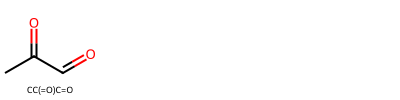

In [ ]:
# --- Display representative molecules from a specific Excel row if needed---
if 'representative_smiles_by_excel_row' not in locals():
    print("Error: Clustering and storing representative smiles has not been performed yet.")
else:
    matching_rows_with_representatives = sorted(list(representative_smiles_by_excel_row.keys()))
    if not matching_rows_with_representatives:
        print("No Excel rows had representative compounds after clustering.")
    else:
        print(matching_rows)
        try:
            # Specify the index of the Excel row
            excel_row_index_to_display = int(input("Select the index of the Excel row to display representative molecules for: "))

            # Get the list of representative SMILES for this row
            smiles_for_this_row = representative_smiles_by_excel_row.get(excel_row_index_to_display, [])

            if smiles_for_this_row:
                print(f"Displaying representative molecules for Excel row index: {excel_row_index_to_display}")
                print(f"Found {len(smiles_for_this_row)} representative simulated product(s) for this row.")
                mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles_for_this_row if Chem.MolFromSmiles(smi) is not None]
                legends_to_draw = [smi for smi in smiles_for_this_row if Chem.MolFromSmiles(smi) is not None]

                # Draw if there are valid molecules
                if mols_to_draw:
                    img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=4, subImgSize=(100, 100),
                                             legends=legends_to_draw,
                                             maxMols=len(mols_to_draw), useSVG=True)
                    display(img)
                else:
                    print("No valid representative molecules found for this row after clustering.")
            else:
                print(f"No representative molecules found for Excel row index: {excel_row_index_to_display}")

        except ValueError:
            print("Invalid input. Please enter a valid integer row index.")

**8. Possible pathways and energy calculations for a pecific matching compound in a specific matching row**


Excel rows with matching compounds:
[np.int64(0), np.int64(5), np.int64(11), np.int64(12), np.int64(40), np.int64(46), np.int64(61), np.int64(65), np.int64(76), np.int64(83), np.int64(92), np.int64(95), np.int64(113), np.int64(124), np.int64(132), np.int64(136), np.int64(156), np.int64(164), np.int64(278), np.int64(387)]
Enter the Excel row index to trace pathways for: 5

Found 3 matching simulated product(s) for Excel row index 5.

Clustering 3 matching compounds with cutoff 0.5...
Clustering resulted in 3 representative compound(s).

Representative compounds after clustering:
1: CC(C=O)=CC=O
2: CC1=CCOC1=O
3: CC(=O)C=CC=O
Select the number of the representative compound to trace pathways for (1 to 3): 2

Tracing ALL pathways for representative SMILES: CC1=CCOC1=O
Found 1 unique pathway(s):
--- Pathway 1 ---
Step 0: Initial reactant: Cc1cccc(C)c1
Step 1: Reactant: Cc1cccc(C)c1 --(Rule 44)--> Product: CC12C=CC(OO)C(C)(OO1)C2O
Step 2: Reactant: CC12C=CC(OO)C(C)(OO1)C2O --(Rule 53)--> P

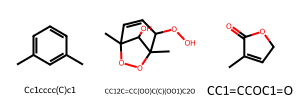

------------------------------
Enter the index of the pathway to use for DFT calculation (1 to 1), or type '0' to skip DFT: 0
Exiting pathway selection and skipping DFT preparation.
No pathway was selected or the selected pathway was empty. DFT preparation skipped.


In [ ]:
# Define a cutoff for clustering the matching compounds for a specific row
clustering_cutoff_pathway = 0.5

matching_rows = sorted(list(matching_smiles_by_excel_row.keys()))

if not matching_rows:
    print("No Excel rows had matching generated compounds.")
else:
    print("\nExcel rows with matching compounds:")
    print(matching_rows)

    try:
        selected_row_index = int(input(f"Enter the Excel row index to trace pathways for: "))

        # Check if the entered row index is in the list of matching rows
        if selected_row_index not in matching_rows:
            print(f"Error: Row index {selected_row_index} did not have any matching compounds.")
        else:
            # Get the list of simulated SMILES that matched this specific Excel row
            smiles_for_row_all = matching_smiles_by_excel_row.get(selected_row_index, [])

            # Check any matching simulated products for this row
            if not smiles_for_row_all:
                 print(f"Error: No matching simulated smiles found for Excel row index: {selected_row_index}")
            else:
                print(f"\nFound {len(smiles_for_row_all)} matching simulated product(s) for Excel row index {selected_row_index}.")

                # --- Perform Clustering on the matching compounds for this row ---
                print(f"\nClustering {len(smiles_for_row_all)} matching compounds with cutoff {clustering_cutoff_pathway}...")
                mols_to_cluster = [Chem.MolFromSmiles(smi) for smi in smiles_for_row_all if Chem.MolFromSmiles(smi) is not None]

                if len(mols_to_cluster) == 0:
                    print("No valid molecules to cluster for this row after RDKit parsing.")
                    representative_smiles = []
                else:
                    representative_mols = cluster_and_filter(mols_to_cluster, clustering_cutoff_pathway)
                    representative_smiles = [Chem.MolToSmiles(mol) for mol in representative_mols]

                    print(f"Clustering resulted in {len(representative_smiles)} representative compound(s).")

                # --- Trace Pathways for Representative Compounds ---
                all_representative_pathways = {}
                product_smiles_to_trace = None

                if not representative_smiles:
                    print("No representative compounds found after clustering to trace pathways for.")
                else:
                    print("\nRepresentative compounds after clustering:")
                    for i, smiles in enumerate(representative_smiles):
                        print(f"{i+1}: {smiles}")

                    # Select which representative SMILES to trace pathways for
                    representative_smiles_index_input = input(f"Select the number of the representative compound to trace pathways for (1 to {len(representative_smiles)}): ")

                    try:
                        representative_smiles_index_to_trace = int(representative_smiles_index_input) - 1

                        # Check if the entered index for representative SMILES selection is valid
                        if 0 <= representative_smiles_index_to_trace < len(representative_smiles):
                            product_smiles_to_trace = representative_smiles[representative_smiles_index_to_trace]

                            print(f"\nTracing ALL pathways for representative SMILES: {product_smiles_to_trace}")

                            # Trace ALL unique pathways leading to the selected representative product
                            traced_pathways = trace_reaction_path_all(product_smiles_to_trace, reaction_history)

                            # Check if any pathways were found
                            if traced_pathways:
                                print(f"Found {len(traced_pathways)} unique pathway(s):")

                                # Temporarily store the SMILES sequences of the displayed pathways for selection
                                displayed_pathways = []

                                for path_index, pathway in enumerate(traced_pathways):
                                    print(f"--- Pathway {path_index + 1} ---")

                                    pathway_molecules = []
                                    legends = []
                                    current_pathway_smiles = []

                                    # Get the initial reactant from the first step of the pathway
                                    initial_reactant_smi = pathway[0][0] if pathway else None
                                    # If the initial reactant is valid, add it to the lists for display and storage
                                    if initial_reactant_smi and Chem.MolFromSmiles(initial_reactant_smi) is not None:
                                         pathway_molecules.append(Chem.MolFromSmiles(initial_reactant_smi))
                                         legends.append(initial_reactant_smi)
                                         current_pathway_smiles.append(initial_reactant_smi)
                                         print(f"Step 0: Initial reactant: {initial_reactant_smi}")
                                    else:
                                         print(f"Warning: Initial reactant '{initial_reactant_smi}' in pathway {path_index + 1} is not a valid molecule and will not be displayed.")

                                    # In the current pathway
                                    for j, step in enumerate(pathway):
                                        reactant, rxn_index, product=step
                                        product_mol = Chem.MolFromSmiles(product)

                                        # Check if the product molecule was successfully created and add it
                                        if product_mol is not None:
                                            # Check to avoid duplicates in drawing
                                            if product not in legends:
                                                 pathway_molecules.append(Chem.MolFromSmiles(product))
                                                 legends.append(product)
                                            current_pathway_smiles.append(product)
                                            print(f"Step {j+1}: Reactant: {reactant} --(Rule {rxn_index})--> Product: {product}")
                                        else:
                                             print(f"Warning: Product '{product}' from step {j+1} in pathway {path_index + 1} is not a valid molecule and will not be displayed.")


                                    # If there are molecules to display in this pathway
                                    if pathway_molecules:
                                        try:
                                            img = Draw.MolsToGridImage(pathway_molecules, molsPerRow=min(len(pathway_molecules), 6),
                                                                       subImgSize=(100, 100), legends=legends, maxMols=len(pathway_molecules), useSVG=True)
                                            display(img)
                                        except Exception as e:
                                            print(f"Error generating image for pathway {path_index + 1}: {e}")
                                    else:
                                        print(f"No valid molecules to display for pathway {path_index + 1}.")

                                    print("-" * 30)
                                    displayed_pathways.append(current_pathway_smiles)

                                # ----------- Pathway Selection for DFT -------------#
                                selected_pathway_smiles = None
                                while True:
                                     # Select one of the displayed pathways by index for DFT calculation or exit
                                    pathway_selection_input = input(f"Enter the index of the pathway to use for DFT calculation (1 to {len(displayed_pathways)}), or type '0' to skip DFT: ")
                                    if pathway_selection_input.lower() == '0':
                                        print("Exiting pathway selection and skipping DFT preparation.")
                                        break
                                    try:
                                         selected_pathway_index = int(pathway_selection_input) - 1
                                         # Check if the entered pathway index is valid
                                         if 0 <= selected_pathway_index < len(displayed_pathways):
                                             # Retrieve the list of SMILES for the selected pathway
                                             selected_pathway_smiles = displayed_pathways[selected_pathway_index]
                                             print(f"Pathway {selected_pathway_index + 1} selected for DFT preparation.")
                                             break
                                         else:
                                             print(f"Invalid pathway index. Please enter a number between 1 and {len(displayed_pathways)}.")
                                    except ValueError:
                                         print("Invalid input. Please enter an integer or 'exit'.")

                                print("=" * 40)

                            else:
                                 print(f"No pathways found for representative product {product_smiles_to_trace}")

                        else:
                             print(f"Error. Please enter a number between 1 and {len(representative_smiles)}.")

                    except ValueError:
                         print("Error. Please enter a number.")

    except ValueError:
        print("Invalid input for Excel row index. Please enter an integer.")

#----- DFT calculation -----#

# Check if a pathway was successfully selected
if 'selected_pathway_smiles' in locals() and selected_pathway_smiles:
    print("\nPreparing molecules from the selected pathway for DFT calculation: ")

    # Displaying atom indices
    IPythonConsole.drawOptions.addAtomIndices = True

    # Prefix for the file name
    prefix = "Name_"

    smiles_list_for_dft = selected_pathway_smiles
    print(f"Processing {len(smiles_list_for_dft)} molecule(s) from the selected pathway for DFT.")

    for i, smi in enumerate(smiles_list_for_dft):
      mol = Chem.MolFromSmiles(smi)
      if mol is None:
          print(f"Could not parse SMILES from selected pathway: {smi}. Skipping DFT prep for this molecule.")
          continue

      mol = Chem.AddHs(mol)

      # Attempt to generate a 3D conformation for the molecule
      try:
          Chem.AllChem.EmbedMolecule(mol)
          if mol.GetNumAtoms() >= 2 and mol.GetNumConformers() > 0:
               pass

      except Exception as e:
          print(f"Could not generate 3D conformation for {smi} (from selected pathway): {e}. Skipping 3D processing for DFT prep.")
          display(mol)
          continue

      # Save the molecule's 3D coordinates to an XYZ file
      filename = f"{prefix}pathway_row_{selected_row_index}_mol_{i+1}.xyz"
      try:
          Chem.MolToXYZFile(mol, filename)
      except Exception as e:
          print(f"Could not save XYZ file for {smi}: {e}")
          display(mol)
          continue

      # Information about the processed molecule
      print(f"Molecule: {smi}")
      print(f"saved to file:{filename}")

else:
    print("No pathway was selected or the selected pathway was empty. DFT preparation skipped.")

**DFT Calculation**

In [ ]:
filenames = [f"{prefix}pathway_row_{selected_row_index}_mol_{i+1}.xyz" for i in range(len(smiles_list_for_dft))]

print("\nStarting DFT calculations...")

dft_results = {}

for i, smi in enumerate(smiles_list_for_dft):
    filename = f"{prefix}pathway_row_{selected_row_index}_mol_{i+1}.xyz"

    print(f"\nProcessing Molecule {i+1}: SMILES: {smi}")

    mol_rdkit = Chem.MolFromSmiles(smi)

    if mol_rdkit is None:
        print(f"  Skipping DFT: Could not parse SMILES {smi} into an RDKit molecule.")
        dft_results[smi] = "Skipped: Invalid SMILES"
        continue

    # Add explicit hydrogen atoms
    mol_rdkit = Chem.AddHs(mol_rdkit)

    # Attempt to generate a 3D conformation and optimize it
    try:
        # Try ETKDGv2 for conformer generation
        params = AllChem.ETKDGv2()
        params.randomSeed = 42 # for reproducibility
        conf_id = AllChem.EmbedMolecule(mol_rdkit, params)

        if conf_id < 0:
            print(f"  Skipping DFT: Could not generate initial 3D conformation for {smi}.")
            dft_results[smi] = "Skipped: No Initial 3D Conformation"
            display(mol_rdkit)
            continue

        # Check if MMFF force field can be applied
        try:
            if AllChem.MMFFOptimizeMolecule(mol_rdkit) == 0:
                 print("  Molecular mechanics optimization converged.")
            else:
                 print("  Molecular mechanics optimization did not converge.")
        except Exception as mmff_e:
             print(f"  Molecular mechanics optimization failed: {mmff_e}")

    except Exception as e:
        print(f"  Skipping DFT: Error during 3D embedding or MM optimization for {smi}: {e}")
        dft_results[smi] = f"Skipped: 3D/MM Error ({e})"
        display(mol_rdkit)
        continue

    # Save the molecule's 3D coordinates to an XYZ file AFTER optimization
    try:
        Chem.MolToXYZFile(mol_rdkit, filename)
        print(f"  Saved 3D coordinates to {filename}")
    except Exception as e:
        print(f"  Skipping DFT: Could not save XYZ file for {smi}: {e}")
        dft_results[smi] = f"Skipped: XYZ Save Error ({e})"
        display(mol_rdkit)
        continue

    # --- Pyscf Calculation ---
    try:
        # Determine charge and spin from RDKit molecule
        mol_charge = Chem.GetFormalCharge(mol_rdkit)
        num_electrons_neutral = sum(atom.GetAtomicNum() for atom in mol_rdkit.GetAtoms())
        num_electrons_actual = num_electrons_neutral - mol_charge
        spin_state_2S = num_electrons_actual % 2
        multiplicity = spin_state_2S + 1

        with open(filename, 'r') as f:
            atom_coords = f.read().splitlines()[2:]

        # Build pyscf molecule object
        mol_pyscf = gto.M(atom=atom_coords, basis='sto-3g', unit='Angstrom',
                          spin=spin_state_2S,
                          charge=mol_charge)

        # Setup and run SCF calculation
        if spin_state_2S == 0:
             mf = scf.RKS(mol_pyscf)
             print("  Using Restricted Kohn-Sham (RKS)...")
        else:
             mf = scf.UKS(mol_pyscf)
             print("  Using Unrestricted Kohn-Sham (UKS)...")

        mf.xc = 'b3lyp'

        energy = mf.kernel()

        if mf.converged:
            print(f"  DFT Calculation Converged. Energy: {energy:.2f}")
            dft_results[smi] = energy
        else:
            print(f"  Skipping DFT: SCF calculation did NOT converge for {smi}. Final energy: {energy:.2f}")
            dft_results[smi] = f"Skipped: SCF Not Converged (Final E: {energy:.2f})"


    except FileNotFoundError:
         print(f"  Skipping DFT: XYZ file not found {filename}. This should not happen if file save succeeded.")
         dft_results[smi] = "Skipped: XYZ file missing unexpectedly"
    except Exception as e:
         print(f"  Skipping DFT: An error occurred during pyscf calculation for {smi}: {e}")
         dft_results[smi] = f"Skipped: Pyscf Error ({e})"

# Conversion of energy unit to kcal/mol
hartree_to_kcal_mol = 627.509

print("\n--- DFT Calculation Summary (kcal/mol) ---")
for smi, result in dft_results.items():
    if isinstance(result, float):
        energy_kcal_mol = result * hartree_to_kcal_mol
        print(f"SMILES: {smi}, Energy (kcal/mol): {energy_kcal_mol:.2f}")
    else:
        print(f"SMILES: {smi}, Status: {result}")

**9. Ranking reaction rules**

In [ ]:
all_known_matching_smiles = set()
for smiles_list in matching_smiles_by_excel_row.values():
    for smiles in smiles_list:
        all_known_matching_smiles.add(smiles)

# Total number of unique known matching smiles
total_unique_known_matching_smiles = len(all_known_matching_smiles)

print(f"Total unique known matching smiles: {total_unique_known_matching_smiles}")

rule_contributions_known = {}
for reactant_smiles, rxn_index, product_smiles in reaction_history:
  if rxn_index != -1 and product_smiles in all_known_matching_smiles:
      rule_contributions_known.setdefault(rxn_index, {'total_known_matches': 0, 'unique_known_matching_products': set()})
      rule_contributions_known[rxn_index]['total_known_matches'] += 1
      rule_contributions_known[rxn_index]['unique_known_matching_products'].add(product_smiles)

ranked_rules = sorted(rule_contributions_known.items(),
                            key=lambda item: (len(item[1]['unique_known_matching_products']) / total_unique_known_matching_smiles * 100) if total_unique_known_matching_smiles > 0 else 0,
                            reverse=True)

# Ranked rules
for rxn_index, stats in ranked_rules:
  percentage_contribution = (len(stats['unique_known_matching_products']) / total_unique_known_matching_smiles * 100) if total_unique_known_matching_smiles > 0 else 0
  print(f"Rule {rxn_index}: Contribution Score = {percentage_contribution:.2f}%" )

Total unique known matching smiles: 176
Rule 4: Contribution Score = 33.52%
Rule 3: Contribution Score = 21.02%
Rule 1: Contribution Score = 14.77%
Rule 8: Contribution Score = 11.93%
Rule 0: Contribution Score = 10.23%
Rule 19: Contribution Score = 9.09%
Rule 13: Contribution Score = 7.39%
Rule 15: Contribution Score = 4.55%
Rule 2: Contribution Score = 3.98%
Rule 22: Contribution Score = 3.98%
Rule 32: Contribution Score = 3.98%
Rule 16: Contribution Score = 3.41%
Rule 23: Contribution Score = 3.41%
Rule 30: Contribution Score = 3.41%
Rule 5: Contribution Score = 2.27%
Rule 26: Contribution Score = 2.27%
Rule 10: Contribution Score = 2.27%
Rule 18: Contribution Score = 2.27%
Rule 21: Contribution Score = 2.27%
Rule 25: Contribution Score = 2.27%
Rule 9: Contribution Score = 1.70%
Rule 20: Contribution Score = 1.14%
Rule 28: Contribution Score = 1.14%
Rule 53: Contribution Score = 1.14%
Rule 55: Contribution Score = 1.14%
Rule 57: Contribution Score = 1.14%
Rule 44: Contribution Score

m-XYL_with_NH3
- n=3>>10;14;8;54;11;12;55;9;2;6;0;1;7;5;4;13;3;15;16;26;28;30;17;18;48;43;44;45;46;21;24;25;27;29;38;39;40;41;42;32;35;36.
- n=4>>10;8;54;14;9;55;11;6;12;7;16;2;1;56;0;4;5;13;3;15(updated)

m-XYL_without_NH3
- n=3>>10;14;8;54;55;11;9;12;6;2;16;1;0;13;5;7;4;15;3;17;48;43;45;46;21;24;38;41;42;35.
- n=4>>14;10;8;54;55;9;11;6;12;7;16;2;1;0;5;4;13;15;3

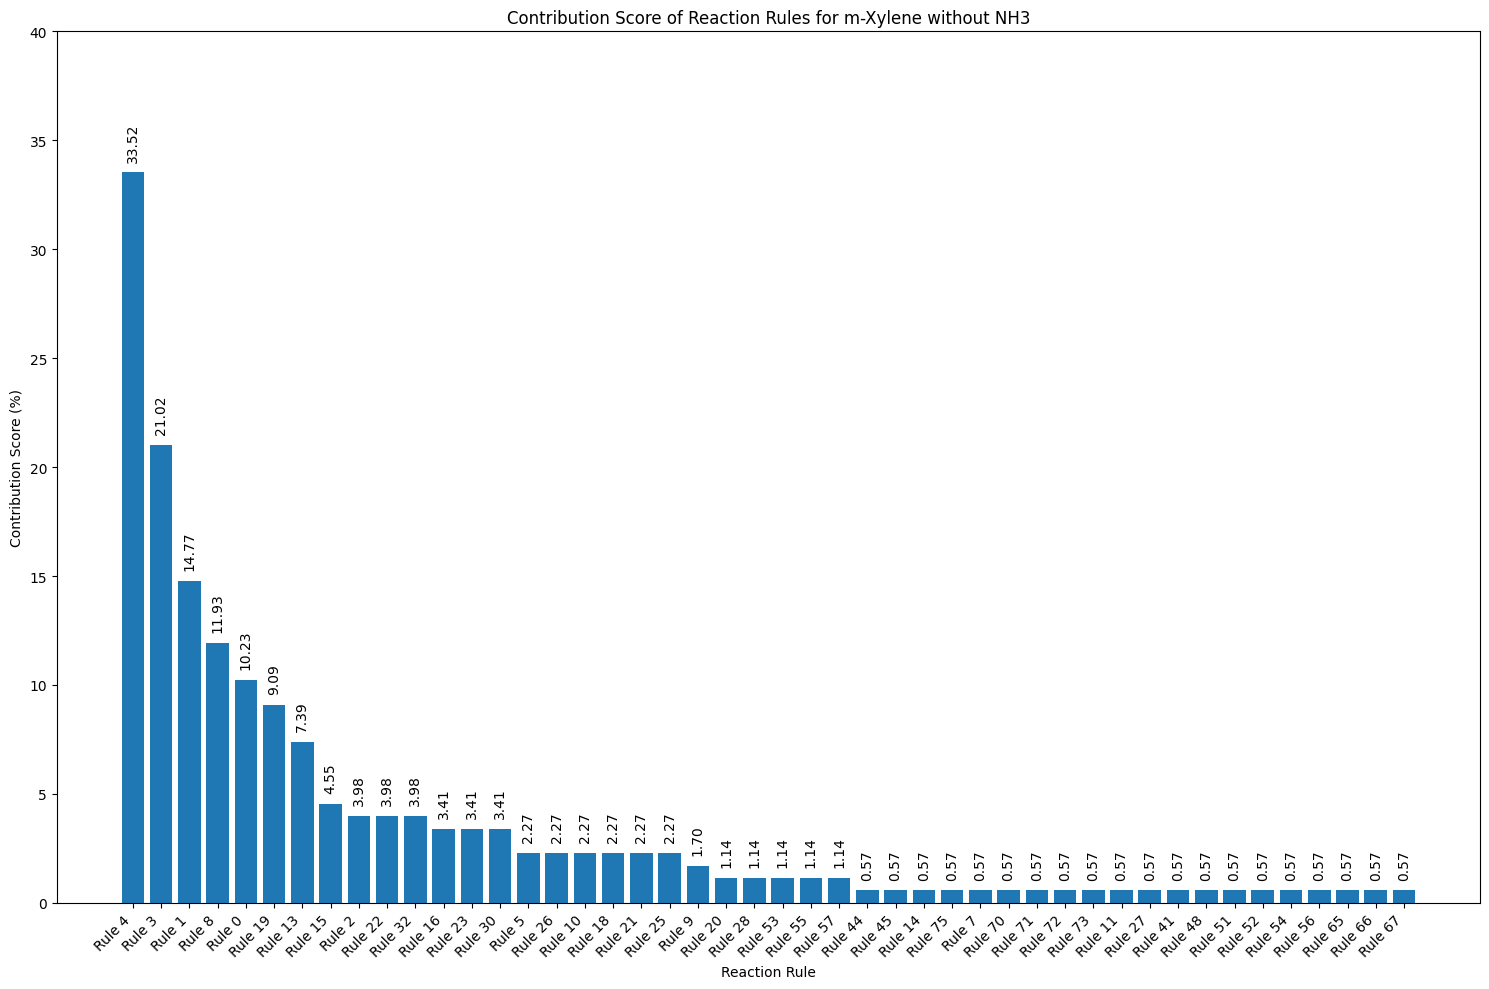

In [ ]:
rule_names = {}

# Plotting the ranked rules
rule_indices_ranked = [item[0] for item in ranked_rules]
contribution_scores = [
    (len(stats['unique_known_matching_products']) / total_unique_known_matching_smiles * 100) if total_unique_known_matching_smiles > 0 else 0
    for rxn_index, stats in ranked_rules
]

rule_names_ranked = [rule_names.get(idx, f'Rule {idx}') for idx in rule_indices_ranked]

plt.figure(figsize=(15, 10))
plt.ylim(0, 40)
bars = plt.bar(range(len(rule_indices_ranked)), contribution_scores)

plt.xticks(range(len(rule_indices_ranked)), rule_names_ranked, rotation=45, ha='right')
plt.xlabel("Reaction Rule")
plt.ylabel("Contribution Score (%)")
plt.title("Contribution Score of Reaction Rules for m-Xylene without NH3")

# Add the contribution score values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.savefig('m-Xylene_without_NH3(n=3).png')
plt.show()

**Search molecules by formular**

In [ ]:
formula_to_search = input('Enter the formular to search:')

# Function to calculate the chemical formula from a SMILES string
def calculate_formula_from_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Get the molecular formula as a string
        return Chem.rdMolDescriptors.CalcMolFormula(mol)
    return None

# Create a set of formulas from the chemical space for efficient searching
chemical_space_formulas = {calculate_formula_from_smiles(smi) for smi in chemical_space if calculate_formula_from_smiles(smi) is not None}

# Check if the target formula is in the set of chemical space formulas
if formula_to_search in chemical_space_formulas:
    print(f"At least one molecule with the formula '{formula_to_search}' is found in the chemical space.")
else:
    print(f"No molecule with the formula '{formula_to_search}' is found in the chemical space.")

# Find all SMILES with that formula:
matching_smiles = [smi for smi in chemical_space if calculate_formula_from_smiles(smi) == formula_to_search]

if matching_smiles:
    print(f"\nFound the following SMILES with the formula '{formula_to_search}':")
    for smi in matching_smiles:
        print(smi)

Enter the formular to search:C6H7NO2
No molecule with the formula 'C6H7NO2' is found in the chemical space.


In [ ]:
# --- Display matching molecules ---
if matching_smiles:
    print(f"\nDisplaying molecules with the formula '{formula_to_search}':")
    mols_to_draw = [Chem.MolFromSmiles(smi) for smi in matching_smiles if Chem.MolFromSmiles(smi) is not None]
    legends_to_draw = [smi for smi in matching_smiles if Chem.MolFromSmiles(smi) is not None]

    # Draw if there are valid molecules
    if mols_to_draw:
        img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=1, subImgSize=(150, 150),
                                 legends=legends_to_draw,
                                 maxMols=len(mols_to_draw), useSVG=True)
        display(img)
    else:
        print("No valid molecules found with this formula to display.")
else:
    print(f"No molecules found with the formula '{formula_to_search}' to display.")

No molecules found with the formula 'C6H7NO2' to display.


**Search a specific molecule by SMILES**

In [ ]:
# Enter the molecula SMILES to search
molecule_to_search_input = input('Enter the SMILES to search:')

# Convert the input SMILES to a canonical SMILES
mol_from_input = Chem.MolFromSmiles(molecule_to_search_input)

if mol_from_input is not None:
    canonical_molecule_to_search = Chem.MolToSmiles(mol_from_input, canonical=True)

    if canonical_molecule_to_search in chemical_space:
        print(f"The molecule '{molecule_to_search_input}' (canonical SMILES: {canonical_molecule_to_search}) is found in the chemical space.")

        # Draw the molecule if found
        mol_to_draw = Chem.MolFromSmiles(canonical_molecule_to_search)
        if mol_to_draw:
            print("\nDisplaying the molecule:")
            img = Draw.MolToImage(mol_to_draw, size=(200, 200))
                                    #legend=canonical_molecule_to_search,
                                  #useSVG=True)

            display(img)
        else:
            print(f"Could not draw the molecule from canonical SMILES: {canonical_molecule_to_search}")

    else:
        print(f"The molecule '{molecule_to_search_input}' (canonical SMILES: {canonical_molecule_to_search}) is not found in the chemical space.")
else:
    print(f"Invalid SMILES input: '{molecule_to_search_input}'. Could not parse.")